In [1]:
from src.data import SegmentationData, SequentialSegmentationData
from nuscenes.nuscenes import NuScenes
from src.models import compile_model
from src.data import compile_data
from src.utils import convert_figure_numpy

from src.tools import plot_nusc_map, get_nusc_maps, add_ego
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import numpy as np

%matplotlib inline

In [2]:
version = 'mini'
dataroot = '/mnt/remote/data/users/anthony/datasets/nuscenes/mini'
nusc = NuScenes(version='v1.0-{}'.format(version),
                dataroot=dataroot,
                verbose=False)

In [3]:
H=900
W=1600
resize_lim=(0.193, 0.225)
final_dim=(128, 352)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=False
xbound=[-50.0, 50.0, 0.5]
ybound=[-50.0, 50.0, 0.5]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]
bsz=4
nworkers=6
grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}
cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': 5,
            }

In [10]:
val_dataset = SegmentationData(nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf,
                               dataroot=dataroot)
dummy_model_config = {
    'receptive_field': 10,
    'n_future': 5
}
seq_val_set = SequentialSegmentationData(nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf,
                               dataroot=dataroot, sequence_length=10)

NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 5}
NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 5}


In [5]:
model = compile_model(grid_conf, data_aug_conf, outC=1, name='basic')
# model = model.to('cuda')

Loaded pretrained weights for efficientnet-b0


In [6]:
model_weights_path = './model_weights/model525000.pt'
# model_weights = torch.load(model_weights_path, map_location='cuda')
model_weights = torch.load(model_weights_path, map_location='cpu')
model.load_state_dict(model_weights)
model.eval()

LiftSplatShoot(
  (camencode): CamEncode(
    (trunk): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(

 number of instances in sample 73
 number of instances in sample 73
 number of instances in sample 74


/home/nikhil/miniconda3/envs/vision/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


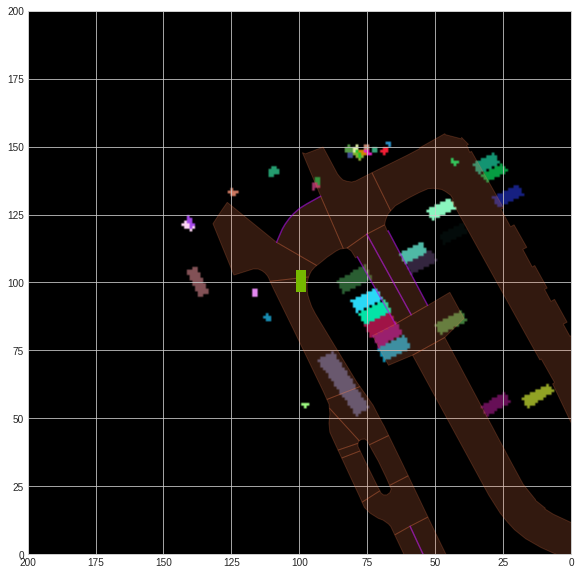

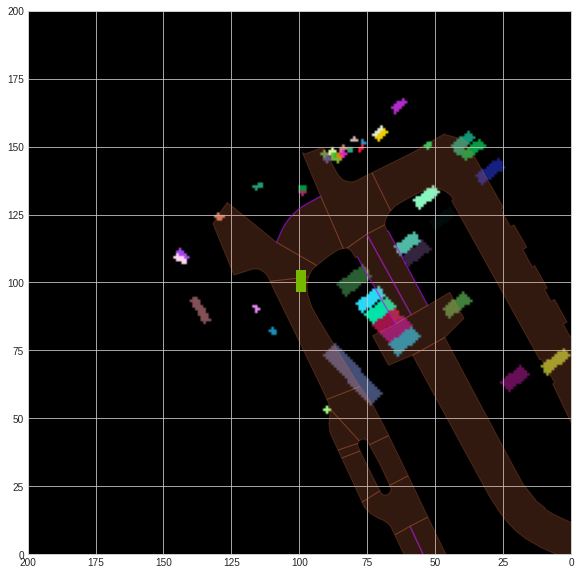

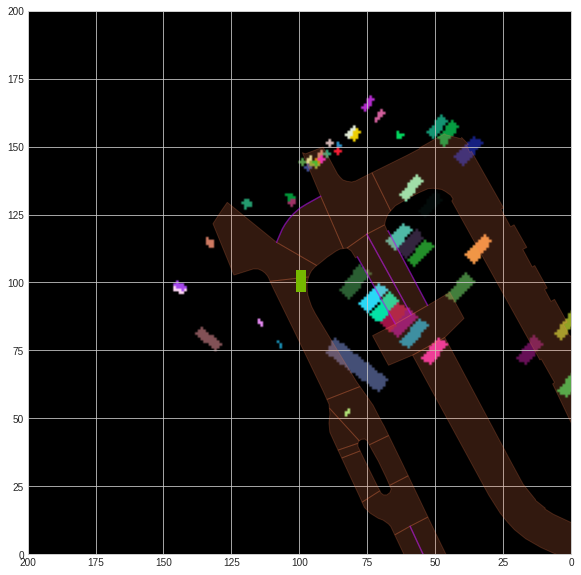

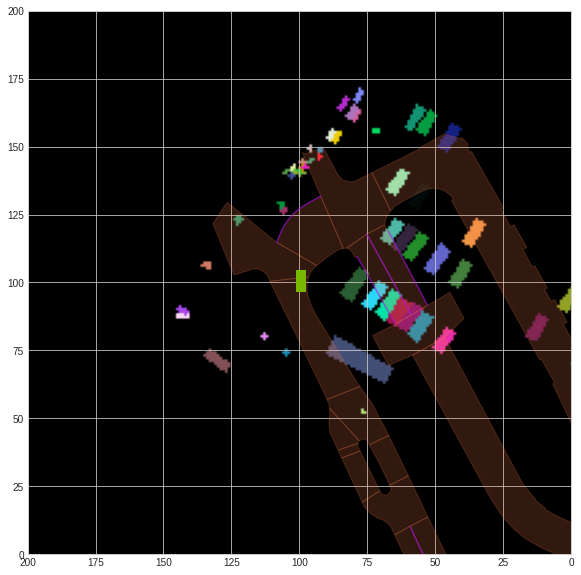

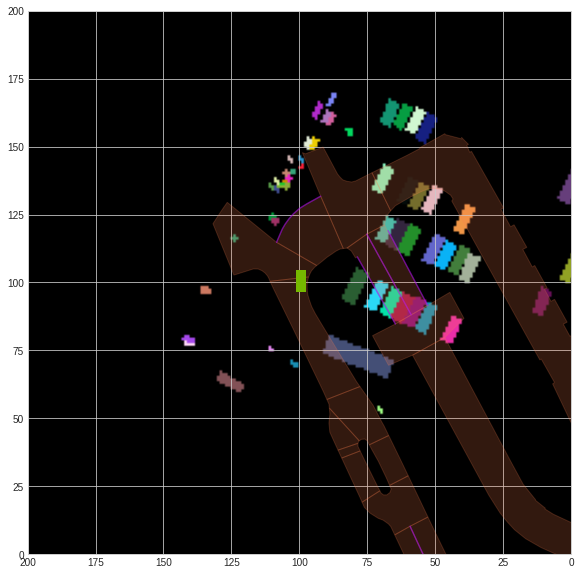

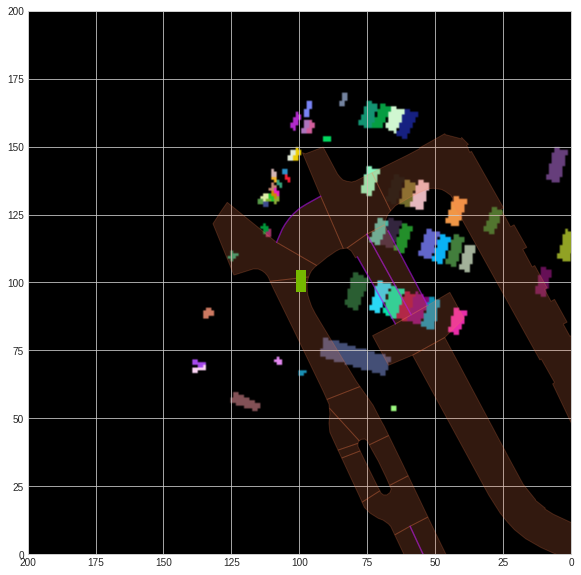

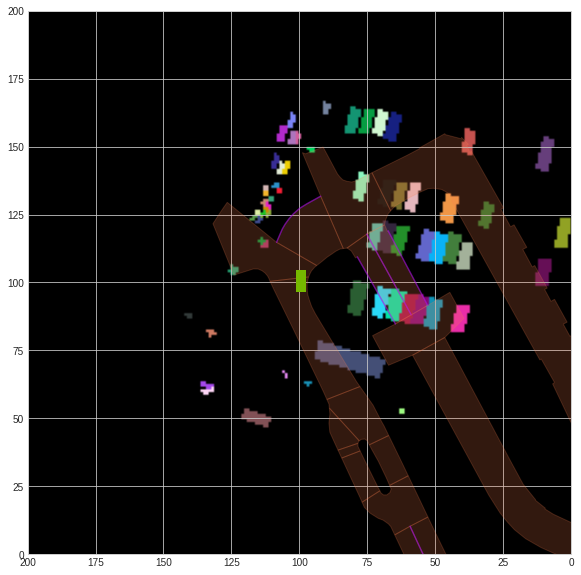

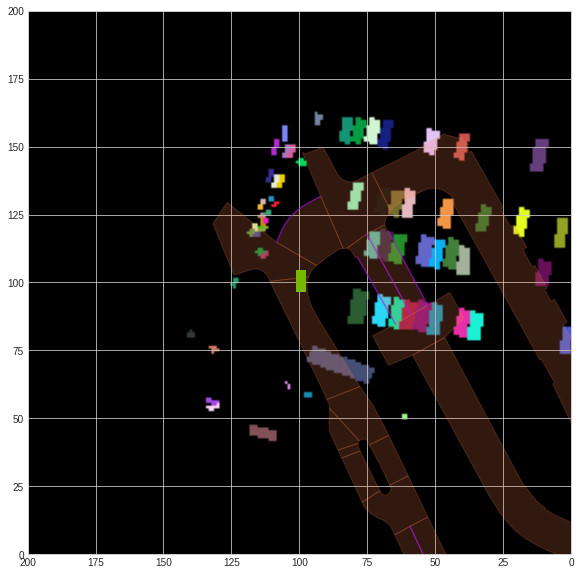

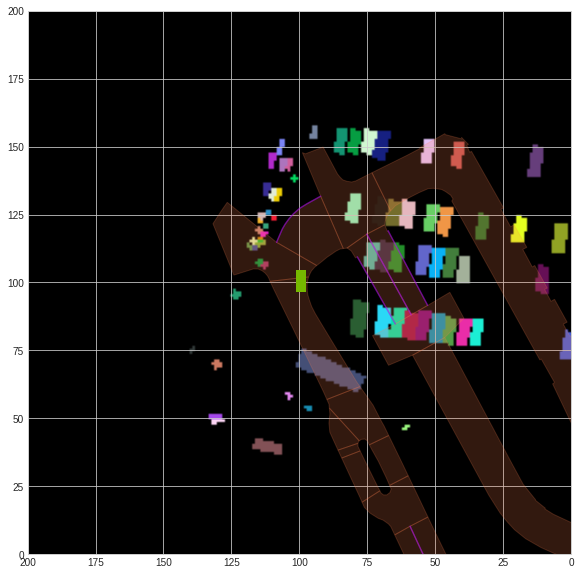

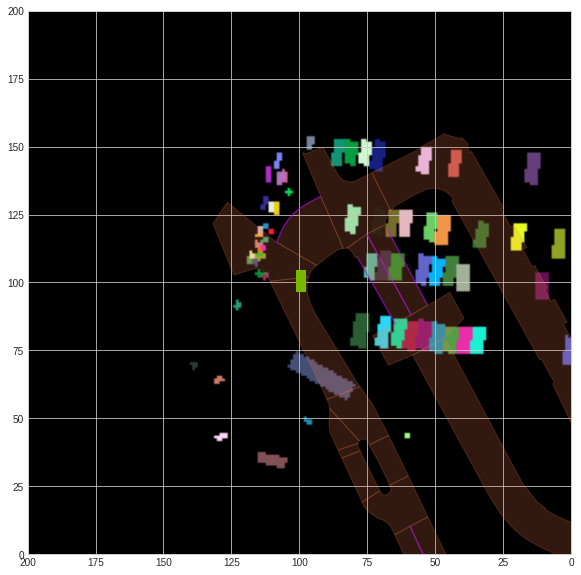

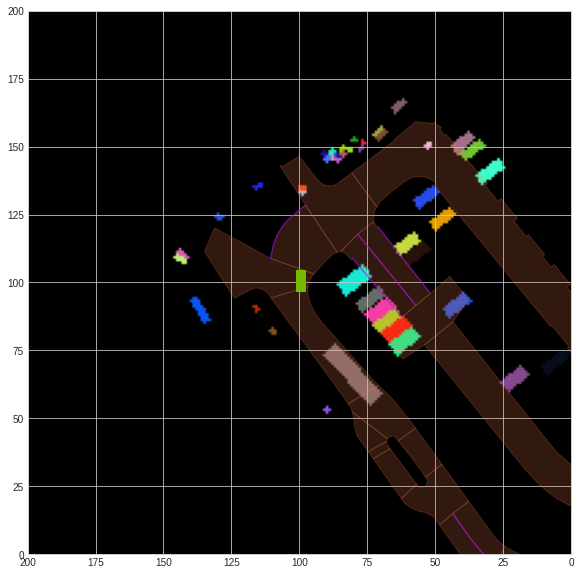

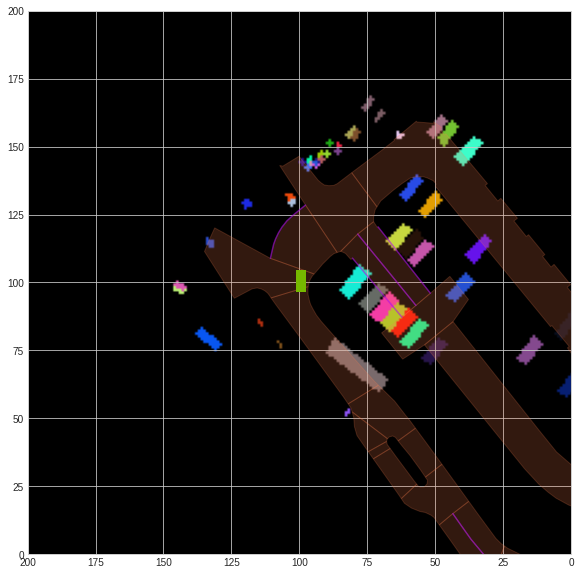

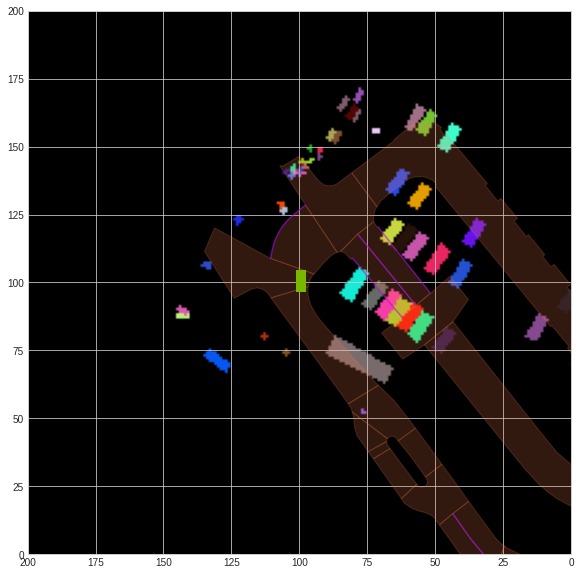

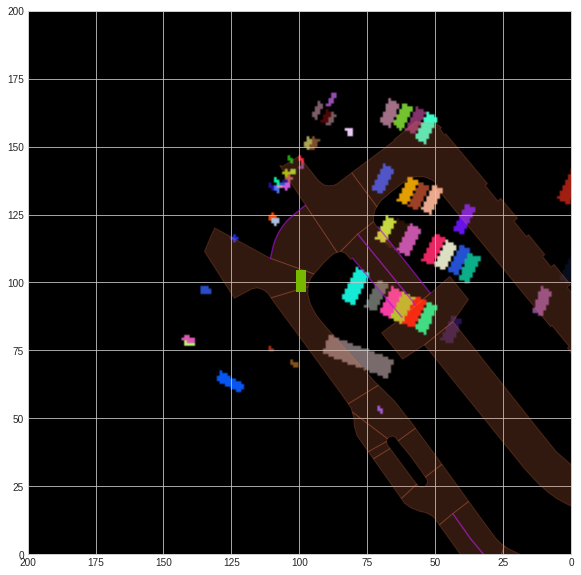

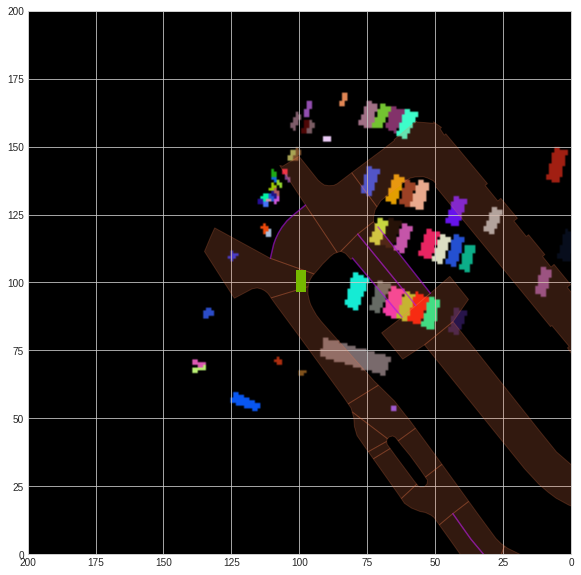

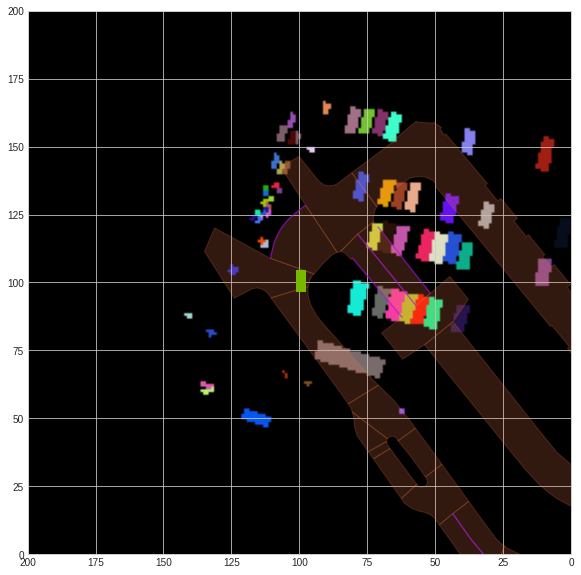

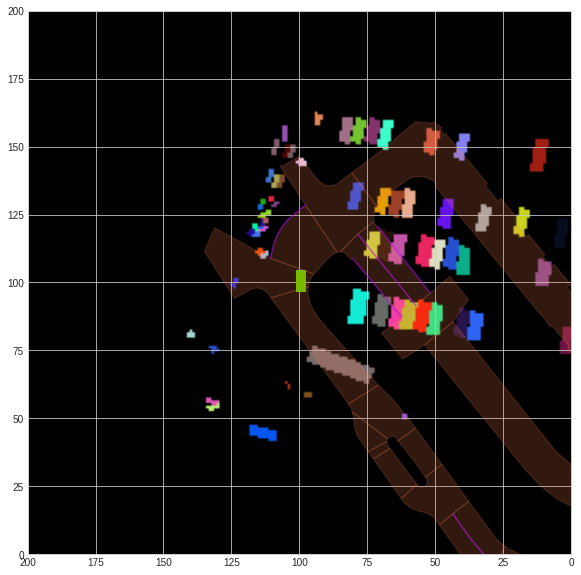

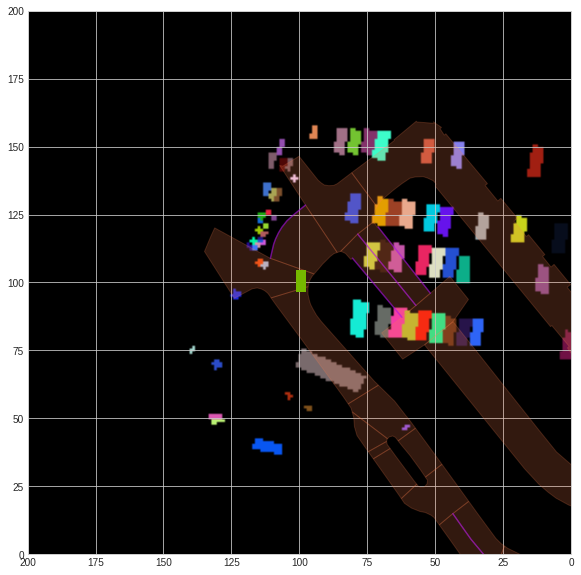

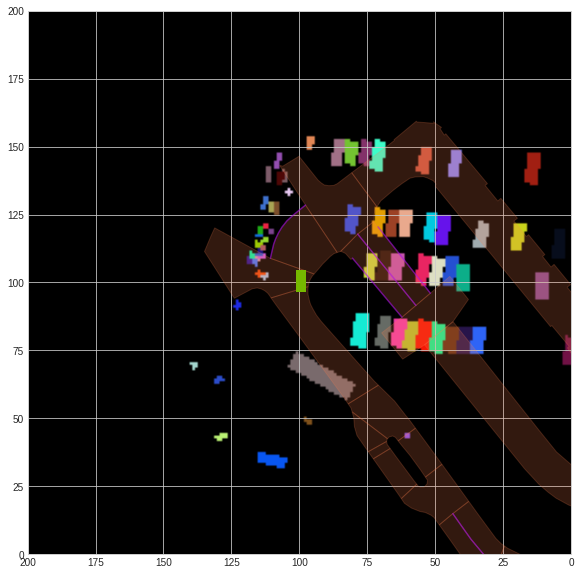

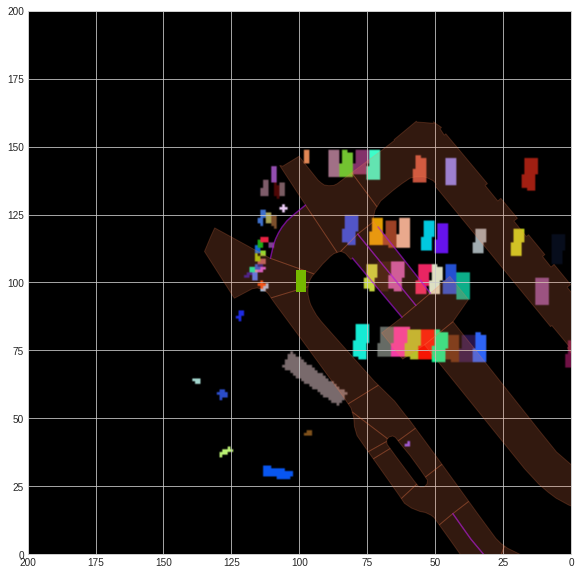

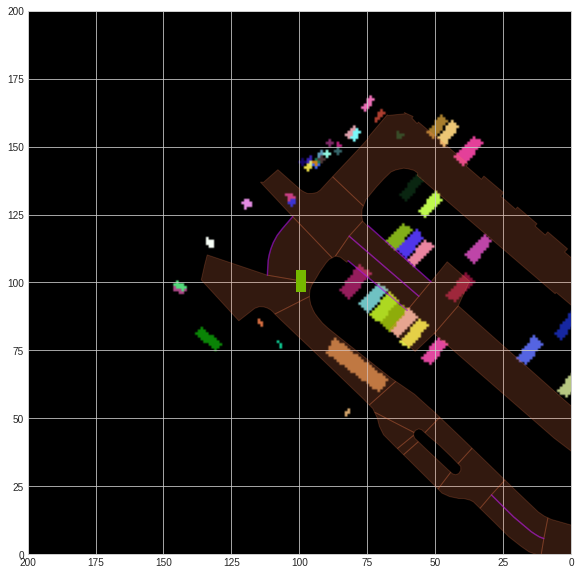

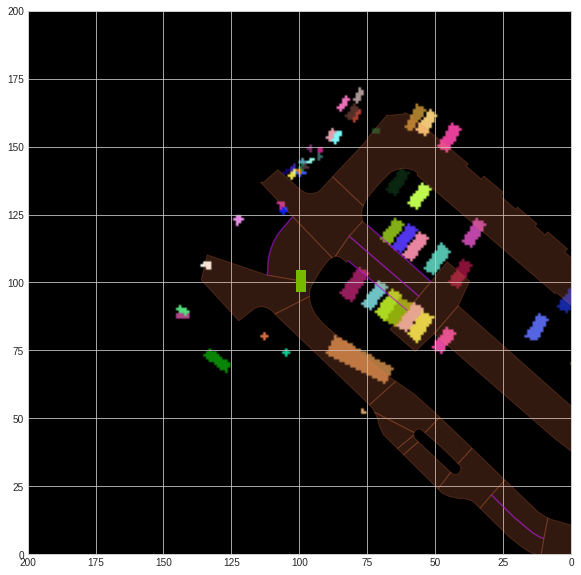

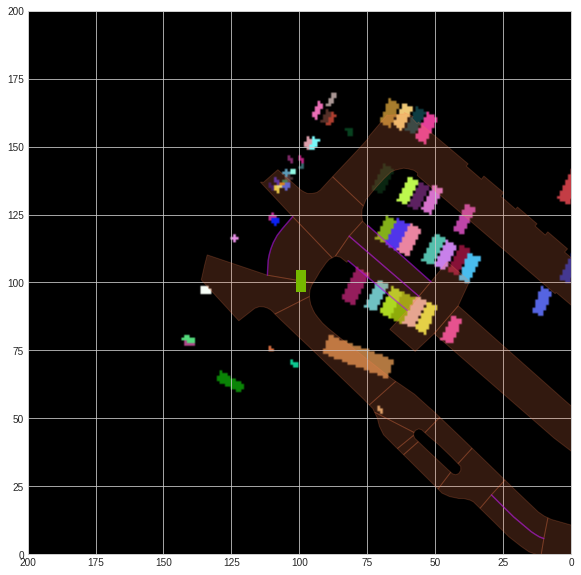

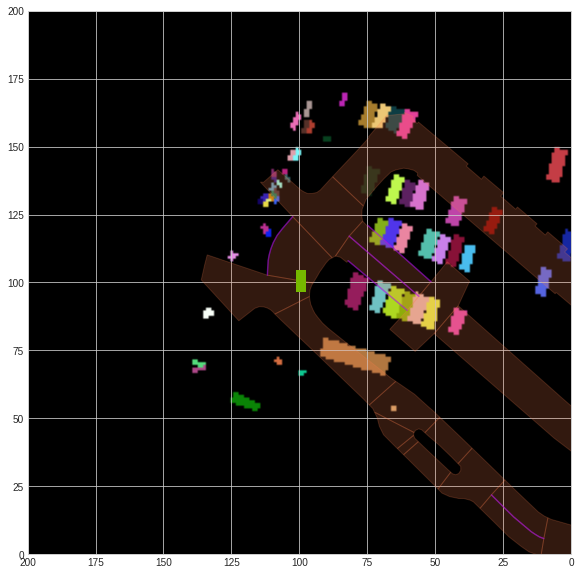

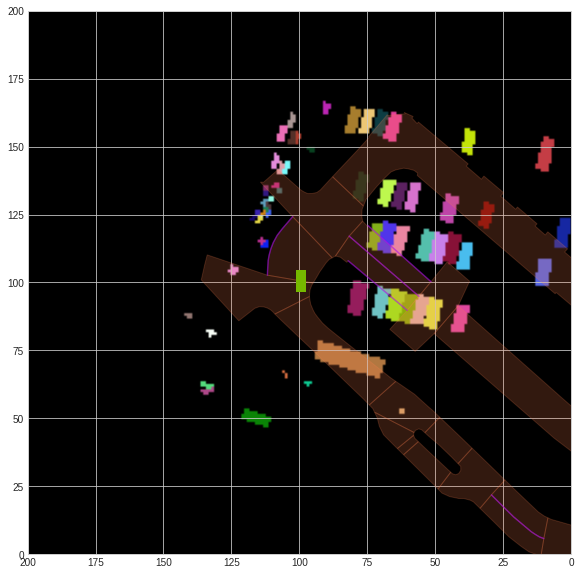

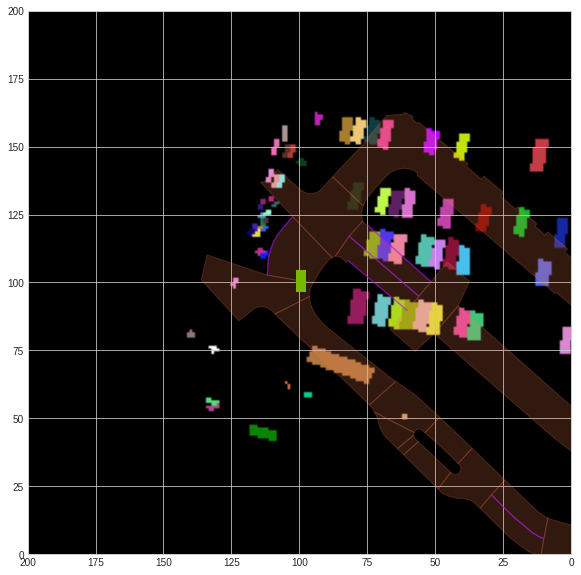

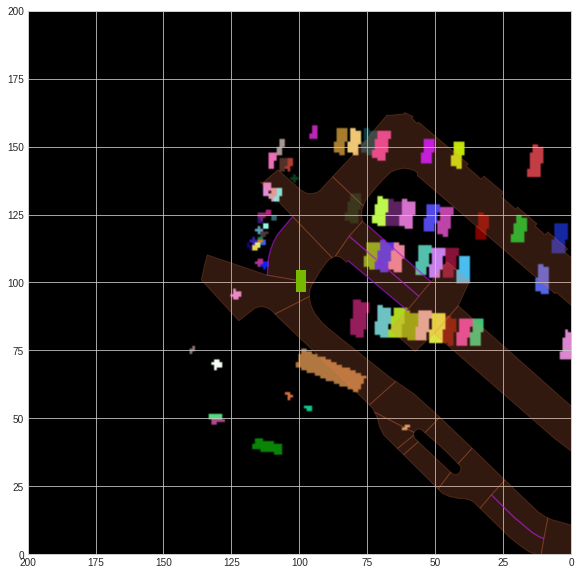

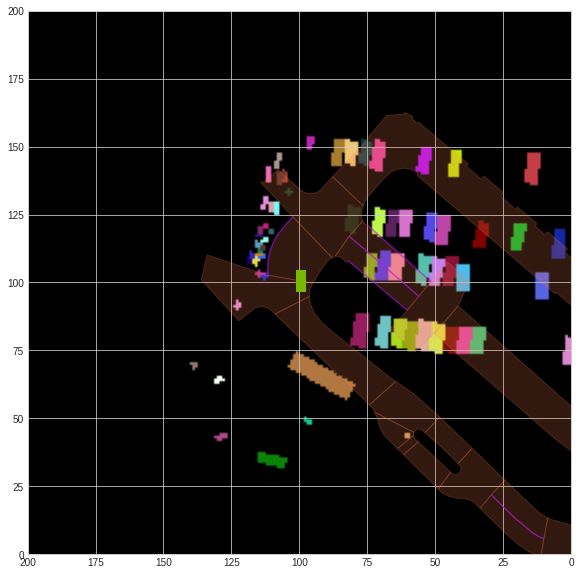

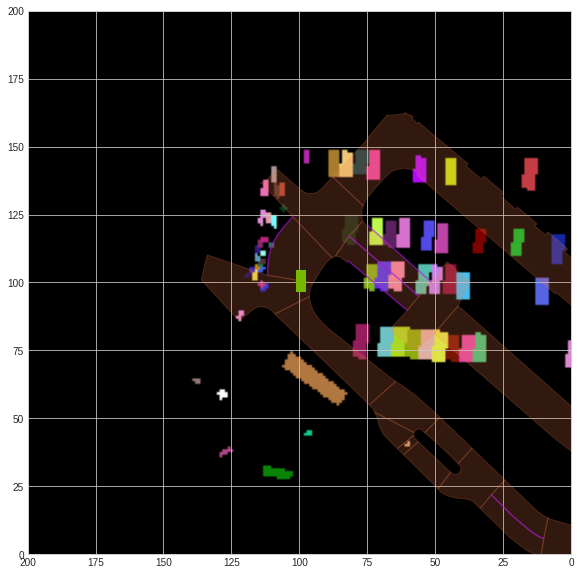

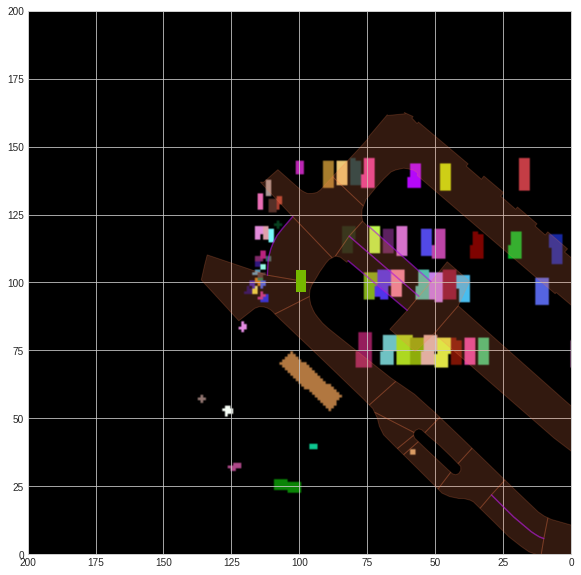

In [21]:
from src.utils import plot_instance_map, _generate_instance_colours
dx, bx = val_dataset.dx[:2], val_dataset.bx[:2]

scene2map = {}
for rec in val_dataset.nusc.scene:
    log = val_dataset.nusc.get('log', rec['log_token'])
    scene2map[rec['name']] = log['location']
nusc_maps = get_nusc_maps(dataroot)

video_np = []
for t in []:
    imgs, rots, trans, intrins, post_rots, post_trans, binimg, future_egomotion, instance_image, instance_map = seq_val_set[t]
    instance_colours = _generate_instance_colours(instance_map)
    print(f' number of instances in sample {len(instance_map)}')
    for time in range(len(instance_image)):
        plt.figure(figsize=(10, 10))
        # plt.imshow(binimg.cpu().numpy())
        plt.imshow(plot_instance_map(instance_image[time], instance_map, instance_colours=instance_colours))
        # plot static map (improves visualization)
        rec = val_dataset.ixes[t]
        plot_nusc_map(rec, nusc_maps, val_dataset.nusc, scene2map, dx, bx)
        plt.xlim((200, 0))
        plt.ylim((0, 200))
        add_ego(bx, dx)
        plt.draw()
    
        video_np.append(convert_figure_numpy(plt.gcf()))
    

In [24]:
index = 15
imgs, rots, trans, intrins, post_rots, post_trans, binimg, future_egomotion = val_dataset[index]
# imgs, rots, trans, intrins, post_rots, post_trans, binimg, future_egomotion = imgs[None, :].cuda(), rots[None, :].cuda(), \
#     trans[None, :].cuda(), intrins[None, :].cuda(), post_rots[None, :].cuda(), post_trans[None, :].cuda(), binimg[None, :].cuda(), \
#     future_egomotion[None, :].cuda()

with torch.no_grad():
    preds = model(imgs, rots, trans, intrins, post_rots, post_trans, future_egomotion)

In [16]:
imgs = imgs[0].cpu()
preds = preds['bev'][0].sigmoid()

In [17]:
imgs.shape

torch.Size([6, 3, 128, 352])

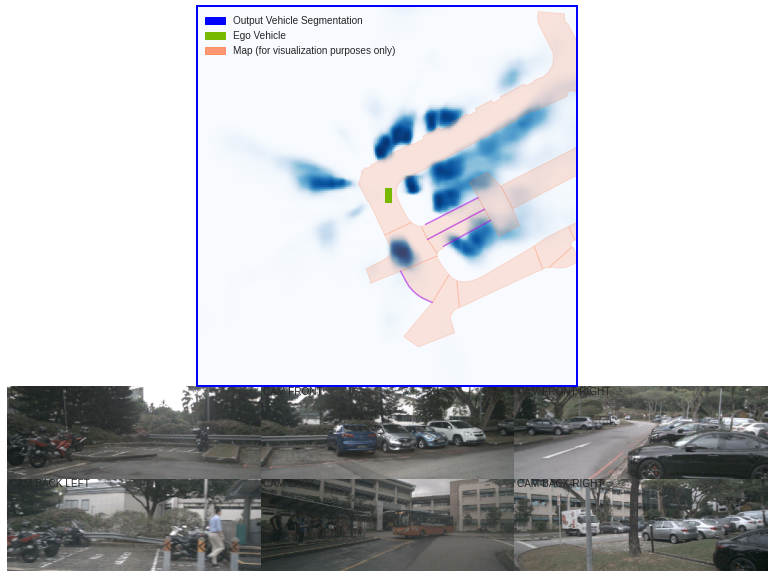

In [13]:
import matplotlib as mpl
import imageio
from PIL import Image
from src.tools import denormalize_img


# Vis with cameras
val = 0.01
fH, fW = final_dim
fig = plt.figure(figsize=(3*fW*val, (1.5*fW + 2*fH)*val))
gs = mpl.gridspec.GridSpec(3, 3, height_ratios=(1.5*fW, fH, fH))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)


plt.clf()
for imgi, img in enumerate(imgs):
    ax = plt.subplot(gs[1 + imgi // 3, imgi % 3])
    showimg = denormalize_img(img)
    # flip the bottom images
    if imgi > 2:
        showimg = showimg.transpose(Image.FLIP_LEFT_RIGHT)
    plt.imshow(showimg)
    plt.axis('off')
    plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

ax = plt.subplot(gs[0, :])
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.setp(ax.spines.values(), color='b', linewidth=2)
plt.legend(handles=[
    mpatches.Patch(color=(0.0, 0.0, 1.0, 1.0), label='Output Vehicle Segmentation'),
    mpatches.Patch(color='#76b900', label='Ego Vehicle'),
    mpatches.Patch(color=(1.00, 0.50, 0.31, 0.8), label='Map (for visualization purposes only)')
], loc=(0.01, 0.86))
plt.imshow(preds.detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='Blues')

# plot static map (improves visualization)
rec = val_dataset.ixes[index]
plot_nusc_map(rec, nusc_maps, val_dataset.nusc, scene2map, dx, bx)
plt.xlim((200, 0))
plt.ylim((0, 200))
add_ego(bx, dx)
plt.draw()

video_np.append(convert_figure_numpy(fig))
